# Using the 4 classes

🔍 Hyperparameter tuning on validation set (multi-class):
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20648
[LightGBM] [Info] Number of data points in the train set: 8704, number of used features: 92
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

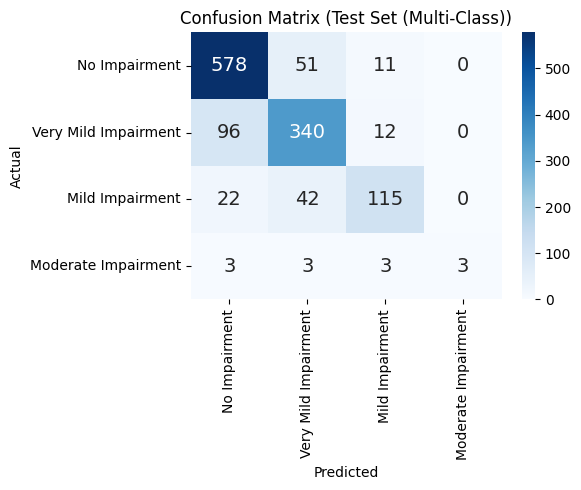

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from lightgbm import LGBMClassifier

# --- Load Datasets ---
df = pd.read_csv("train_features_scaled.csv")
val_df = pd.read_csv("val_features_scaled.csv")
test_df = pd.read_csv("test_features_scaled.csv")

# --- Feature Selection ---
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

f_scores, _ = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.nlargest(120, "F_score")["Feature"])
top_mi = set(mi_df.nlargest(120, "MI_Score")["Feature"])
core_features = list(top_f & top_mi)

# --- Prepare Datasets ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]

# --- Manual Grid Search ---
param_grid = {
    'max_depth': [ 5, 7, 9, 11, 13],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
    'n_estimators': [100, 200, 300]
}

best_score = 0
best_params = {}

print("🔍 Hyperparameter tuning on validation set (multi-class):")
for max_depth, lr, n_est in product(param_grid['max_depth'],
                                    param_grid['learning_rate'],
                                    param_grid['n_estimators']):
    model = LGBMClassifier(
        objective='multiclass',
        num_class=4,
        max_depth=max_depth,
        learning_rate=lr,
        n_estimators=n_est,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_score = balanced_accuracy_score(y_val, val_pred)
    print(f"max_depth={max_depth}, lr={lr}, n_estimators={n_est} → Balanced Acc: {val_score:.4f}")
    if val_score > best_score:
        best_score = val_score
        best_params = {
            'max_depth': max_depth,
            'learning_rate': lr,
            'n_estimators': n_est
        }

print("\n✅ Best Params:", best_params)

# --- Retrain on Train + Val ---
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

clf = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    class_weight='balanced',
    random_state=42,
    **best_params
)
clf.fit(X_combined, y_combined)

# --- Evaluation ---
label_map = {
    0: "No Impairment",
    1: "Very Mild Impairment",
    2: "Mild Impairment",
    3: "Moderate Impairment"
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map.values(), yticklabels=label_map.values(),
                annot_kws={"size": 14})
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# --- Final Evaluation ---
evaluate_set(X_test, y_test, "Test Set (Multi-Class)")


🔍 Hyperparameter tuning on validation set:
[LightGBM] [Info] Number of positive: 6528, number of negative: 2176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20648
[LightGBM] [Info] Number of data points in the train set: 8704, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6528, number of negative: 2176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20648
[LightGBM] [Info] Number of data points in the train set: 8704, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7680, number of negative: 2560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20740
[LightGBM] [Info] Number of data points in the train set: 10240, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/home/alof/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


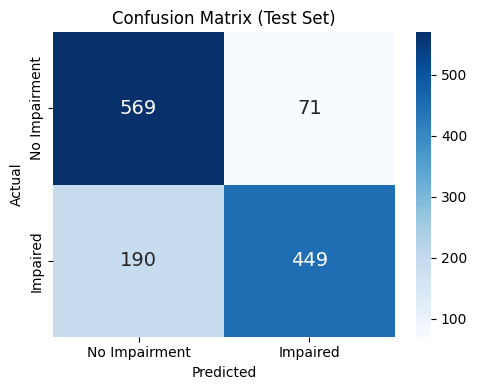

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from lightgbm import LGBMClassifier

# --- Load Datasets ---
df = pd.read_csv("train_features_scaled.csv")
val_df = pd.read_csv("val_features_scaled.csv")
test_df = pd.read_csv("test_features_scaled.csv")

# --- Re-label as binary: 0 = No Impairment, 1 = Any Impairment ---
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)
val_df['label'] = val_df['label'].apply(lambda x: 0 if x == 0 else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 0 else 1)

# --- Feature Selection ---
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

f_scores, _ = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.nlargest(120, "F_score")["Feature"])
top_mi = set(mi_df.nlargest(120, "MI_Score")["Feature"])
core_features = list(top_f & top_mi)

# --- Extract Features and Labels ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]

# --- Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Manual Grid Search using Validation Set ---
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

best_score = 0
best_params = {}

# Class ratio for scale_pos_weight (Impaired : No Impairment)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

print("🔍 Hyperparameter tuning on validation set:")
for max_depth, lr, n_est in product(param_grid['max_depth'],
                                    param_grid['learning_rate'],
                                    param_grid['n_estimators']):
    model = LGBMClassifier(
        objective='binary',
        scale_pos_weight=scale_pos_weight,
        max_depth=max_depth,
        learning_rate=lr,
        n_estimators=n_est,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    val_pred = model.predict(X_val_scaled)
    val_score = balanced_accuracy_score(y_val, val_pred)
    print(f"max_depth={max_depth}, lr={lr}, n_estimators={n_est} → Balanced Acc: {val_score:.4f}")
    if val_score > best_score:
        best_score = val_score
        best_params = {
            'max_depth': max_depth,
            'learning_rate': lr,
            'n_estimators': n_est
        }

print("\n✅ Best Params from validation set:")
print(best_params)
print(f"Best Validation Balanced Accuracy: {best_score:.4f}")

# --- Combine Train + Val for Final Training ---
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])
X_combined_scaled = scaler.fit_transform(X_combined)

# --- Train Final Model on Combined Data ---
clf = LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)
clf.fit(X_combined_scaled, y_combined)

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Binary, Threshold = {threshold})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(),
                yticklabels=label_map_binary.values(),
                annot_kws={"size": 14})
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# --- Evaluate Final Model ---
evaluate_binary(X_test_scaled, y_test, "Test Set", threshold=0.45)
